# Plotting the full integrand in radiation expansion.

After choosing orthonormal radiation mode classes $u_\mathcal{A}, u_\mathcal{B},$ the radiation portion of the field is given by

$$u_r(x,z) = \int_{Z=0}^\infty  \Big( \hat f_\mathcal{A}(Z) \, u_\mathcal{A} (x, Z) + \hat f_\mathcal{B}(Z)\, u_\mathcal{B} (x, Z) \Big) e^{i\beta z} \, dZ$$

Where

$$\begin{align}
\hat{f}_{\mathcal{A}}(Z) & = \int_{-\infty}^\infty f(x) u_{\mathcal{A}}(x,Z) \, dx \\[.1cm]
\hat{f}_{\mathcal{B}}(Z) & = \int_{-\infty}^\infty f(x) u_{\mathcal{B}}(x,Z) \, dx\
\end{align}
$$

are the radiation transforms of the input function f(x).

For symmetric structures, the radiation mode classes $u_\mathcal{A}, u_\mathcal{B}$ are even and odd functions respectively (for real Z for paper method, all Z for our method).

The classes have form 

$$\begin{align}
u_{\mathcal{A}}(x, Z) & = A_{1, j}(Z) \, e^{i Z_j(Z) x} + A_{2, j}(Z) \, e^{-i Z_j(Z) x}  \\[.1cm]
u_{\mathcal{B}}(x, Z) & = B_{1, j}(Z) \, e^{i Z_j(Z) x} + B_{2, j}(Z) \, e^{-i Z_j(Z) x}\, dx\
\end{align}
$$

for $x\in R_j$.

In this notebook we want to look at the full integrands in the radiation integral above, with both the modal coefficients ($A, B$) and the transforms.  

We will use our method of normalizing the classes and an even input function, which should entail that $ \hat{f}_{\mathcal{B}}(Z) \equiv 0.$  With that done we just need to examine the plots of $\hat{f}_{\mathcal{A}}(Z) A_{1,j}(Z)$ and 
$\hat{f}_{\mathcal{A}}(Z) A_{2,j}(Z)$ in the complex plane.  We will start by looking at this for region $R_0$, for which $Z_j(Z) = Z$ and the coefficients are given directly by the normalization procedure.  We will also only be looking at $TE$ fields.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from slab import SlabExact
from fiberamp.fiber.microstruct.bragg import plotlogf
from scipy.optimize import newton
plt.style.use('dark_background')
%matplotlib widget

## Set up waveguide and input function

We choose antiguide since it only has leaky modes.

In [12]:
A = SlabExact(scale=1e-6, Ts=[2, 2, 2],
              ns=[1.44, 1, 1.44], xrefs=[300, 500, 300],
              symmetric=True, wl=1e-6)

In [16]:
def f0(x):
    conds = [(x<-.5), ((-.5<=x)*(x<=.5)), (x>.5)]
    funcs = [0, lambda x: .25-x**2, 0]
    return np.piecewise(x, conds, funcs)

f0_shifted = lambda x: f0(x) +1

### Plot input function and refractive index

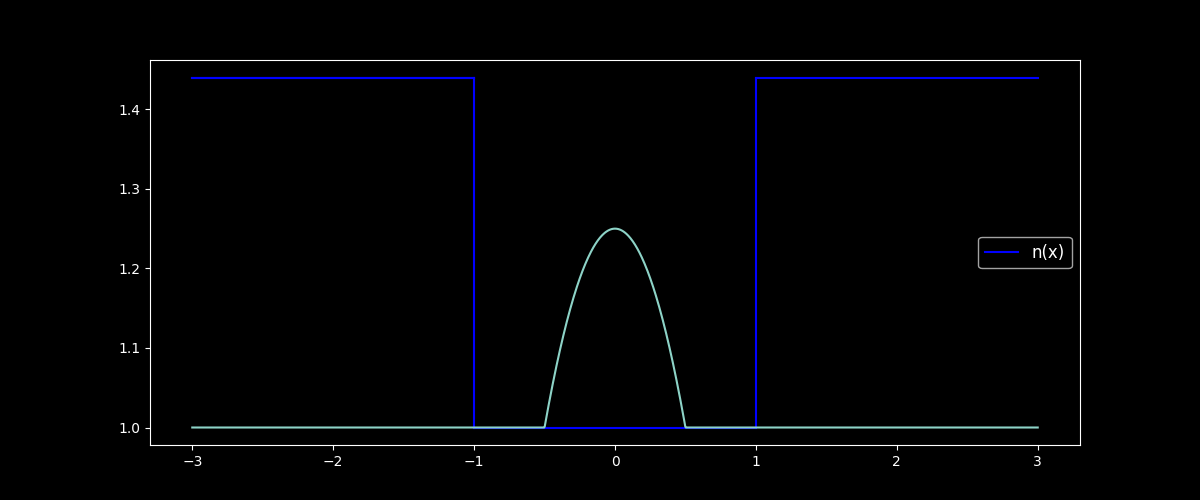

In [17]:
A.plot_refractive_index()
A.add_1d_plot(f0_shifted)

### Get eigenvalue from determinant plot for later use

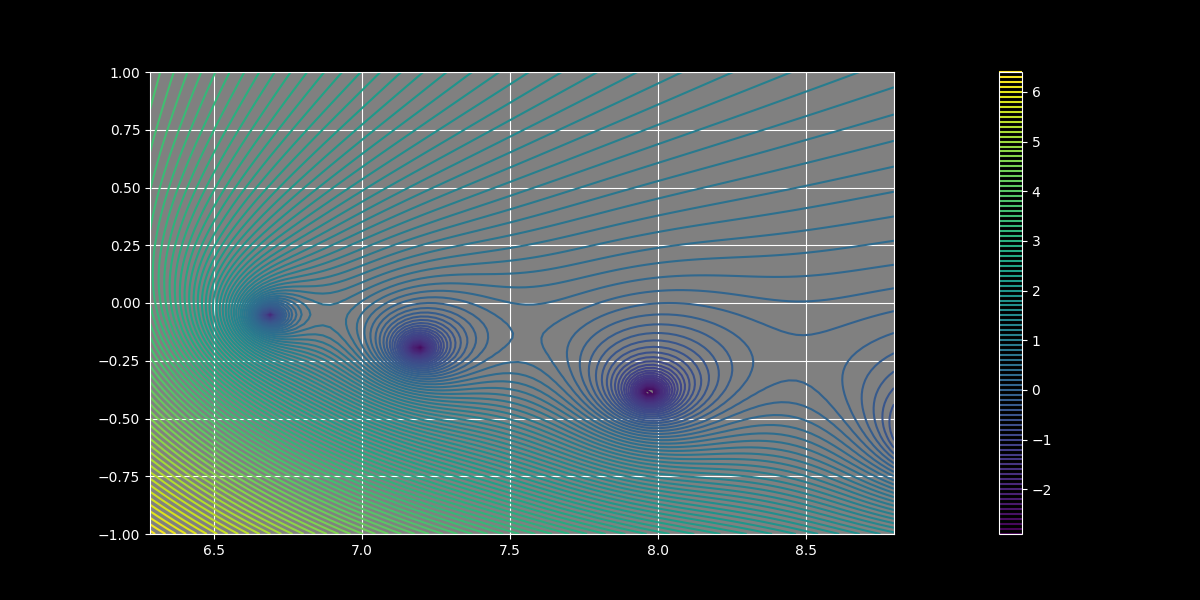

In [18]:
plotlogf(A.determinant_Z,  A.K_low, 1.4*A.K_low, -1, 1, 'TE', 'guided',  iref=100, rref=100, levels=100)

In [19]:
Z = newton(A.determinant_Z, np.array([6.6]), args=('TE', 'guided'))
print(Z)
plt.plot(Z.real, Z.imag, 'ro');

[6.68512884-0.05373814j]


### Define and plot transforms


In [20]:
Propagator = A.propagator()

In [21]:
P_even = Propagator(f0=f0, Lx=-.5, Rx=.5,
                    LZ=0.001, RZ=6, NZ=2,
                    sign='+1', paper_method=False)

P_odd = Propagator(f0=f0, Lx=-.5, Rx=.5,
                   LZ=0.001, RZ=6, NZ=2,
                    sign='-1', paper_method=False)

  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

In [23]:
P_even.transform?

Signature:       P_even.transform(*args, **kwargs)
Type:            vectorize
String form:     <numpy.vectorize object at 0x7f42a7321e70>
File:            ~/.local/lib/python3.10/site-packages/numpy/__init__.py
Docstring:       <no docstring>
Class docstring:
vectorize(pyfunc, otypes=None, doc=None, excluded=None, cache=False,
          signature=None)

Generalized function class.

Define a vectorized function which takes a nested sequence of objects or
numpy arrays as inputs and returns a single numpy array or a tuple of numpy
arrays. The vectorized function evaluates `pyfunc` over successive tuples
of the input arrays like the python map function, except it uses the
broadcasting rules of numpy.

The data type of the output of `vectorized` is determined by calling
the function with the first element of the input.  This can be avoided
by specifying the `otypes` argument.

Parameters
----------
pyfunc : callable
    A python function or method.
otypes : str or list of dtypes, optional
 

#### Even transform

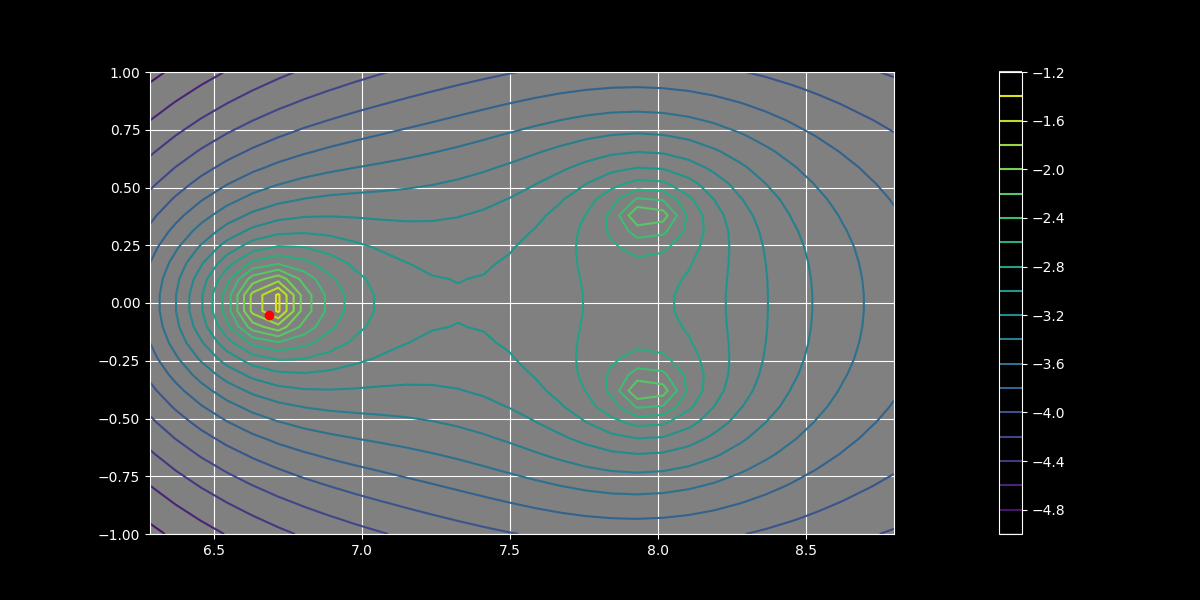

In [24]:
plotlogf(P_even.transform, A.K_low, 1.4*A.K_low, -1, 1, iref=30, rref=30, levels=20)
plt.plot(Z.real, Z.imag, 'ro');

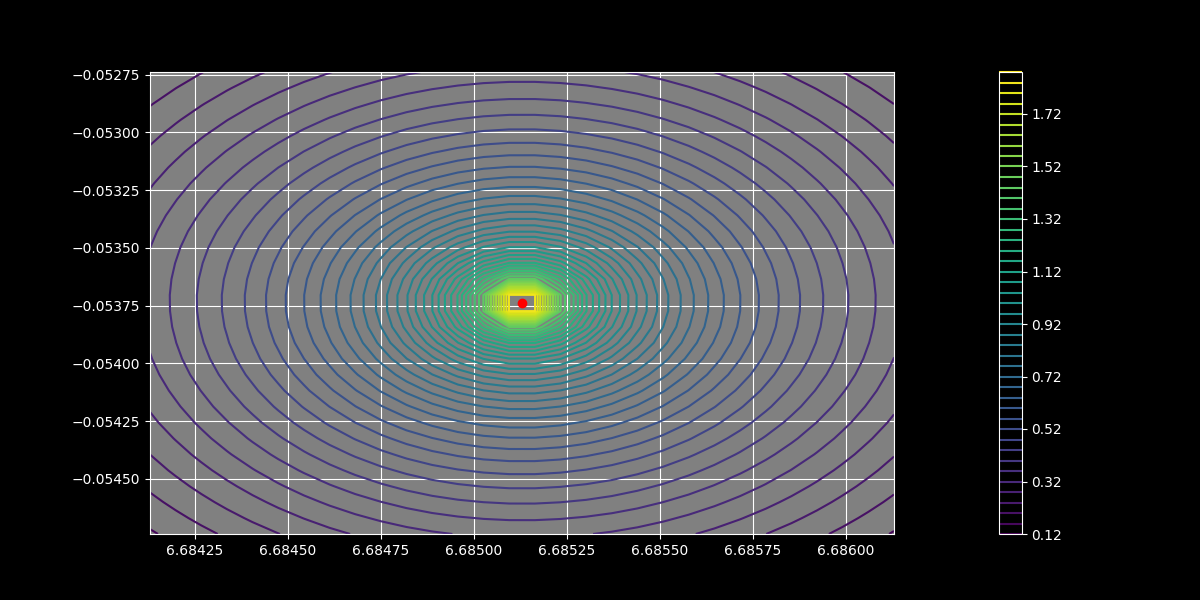

In [25]:
plotlogf(P_even.transform, Z.real-.001, Z.real+.001, Z.imag-.001, Z.imag+.001, iref=30, rref=30, levels=50)
plt.plot(Z.real, Z.imag, 'ro');

#### Odd transform

Just to check, we look at odd transform.  It should be zero:

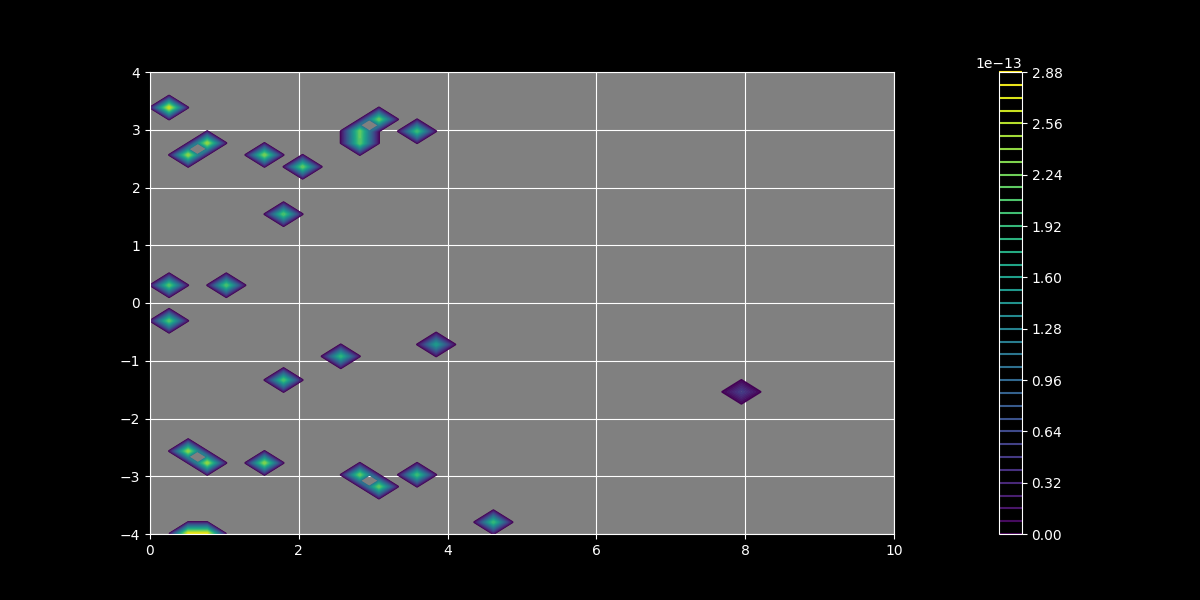

In [26]:
plotlogf(P_odd.transform, 0, 10, -4, 4, iref=40, rref=40, levels=40, log_off=True)

### Define and plot coefficients

Below is a vectorized version of the coefficients.

In [14]:
def coeffs(Z, entry=1):
    M = A.transmission_matrix_Z(Z)
    detM = A.transmission_determinant_Z(Z)
    frac = (-M[..., 1, 0] * detM) / M[..., 0, 1]
    b = np.sqrt(frac, dtype=complex)
    
    factor = M[..., 0, 0].conj() + b - M[..., 0, 1].conj()
    C0 = (b.conj() - M[..., 0, 1]) * factor
    C1 = M[..., 0, 0] * factor
    factor2 = np.sqrt(4 *C0 * C1,
                      dtype=complex)

    if entry ==1:
        return C0 * np.sqrt(2/np.pi) * 1 / factor2
    elif entry == 2:
        return C1 * np.sqrt(2/np.pi) * 1 / factor2
    else:
        raise TypeError('Entry must be 1 or 2')


In [28]:
A.evaluate_fields_Z?

Signature:
A.evaluate_fields_Z(
    Z,
    X,
    field_type='TE',
    mode_type='radiation',
    sign='+1',
    paper_method=True,
)
Docstring: Return value of field with propagation constant Zj(Z) at X.
File:      ~/local/slab/slab.py
Type:      method

#### Coefficient $A_{1,0}$

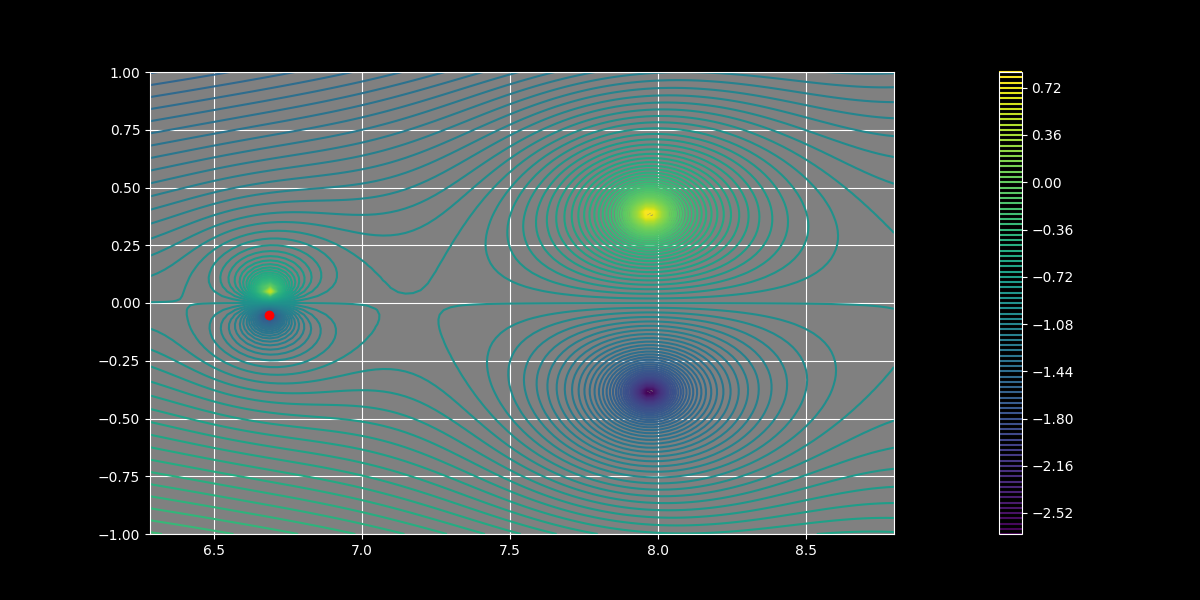

In [15]:
entry = 1
plotlogf(coeffs, A.K_low, 1.4*A.K_low, -1, 1, entry, iref=100, rref=100, levels=100)
plt.plot(Z.real, Z.imag, 'ro');

#### Coefficient $A_{2,0}$

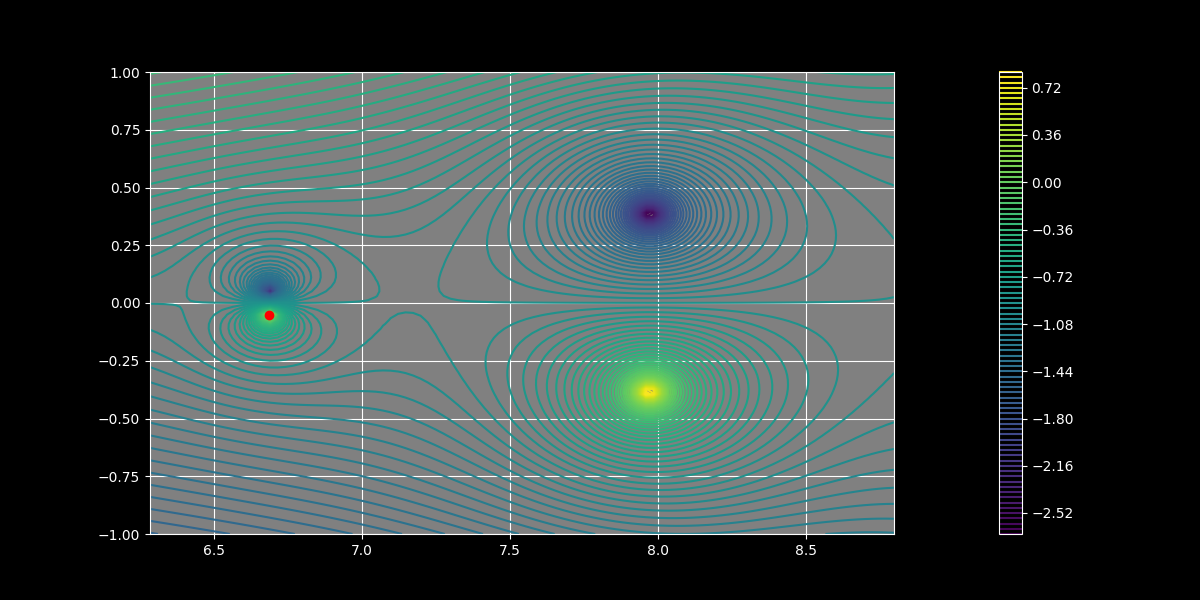

In [16]:
entry = 2
plotlogf(coeffs, A.K_low, 1.4*A.K_low, -1, 1, entry, iref=100, rref=100, levels=100)
plt.plot(Z.real, Z.imag, 'ro');

### Combined transform and coefficients

In [17]:
integrand_1 = lambda Z: coeffs(Z, 1) * P_even.transform(Z)
integrand_2 = lambda Z: coeffs(Z, 2) * P_even.transform(Z)

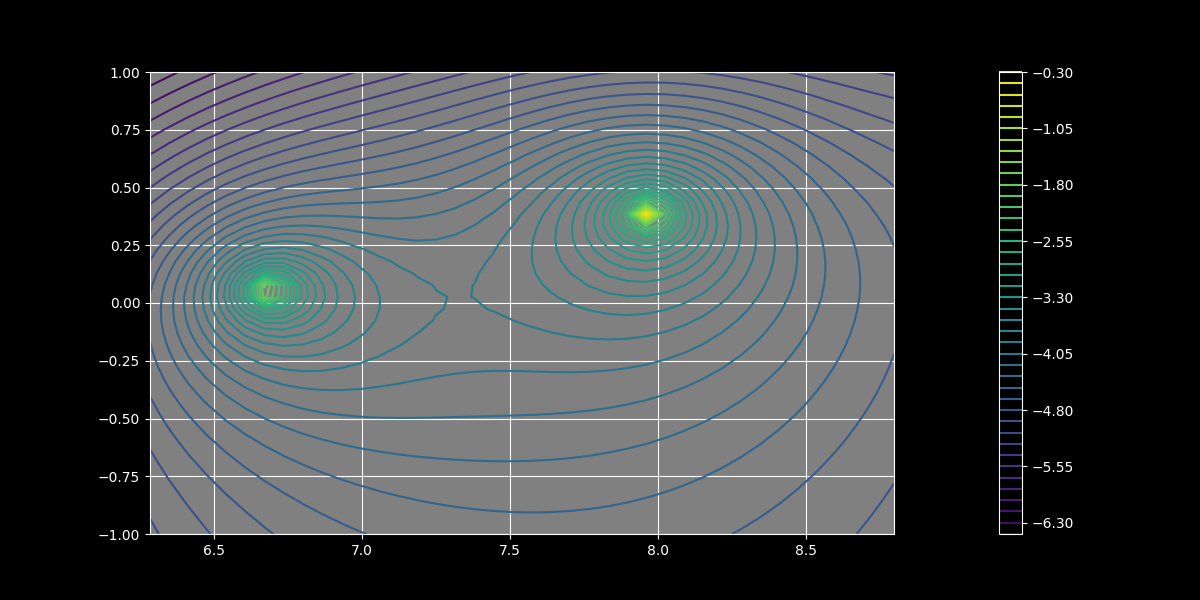

In [18]:
plotlogf(integrand_1, A.K_low, 1.4*A.K_low, -1, 1, iref=40, rref=40, levels=40)

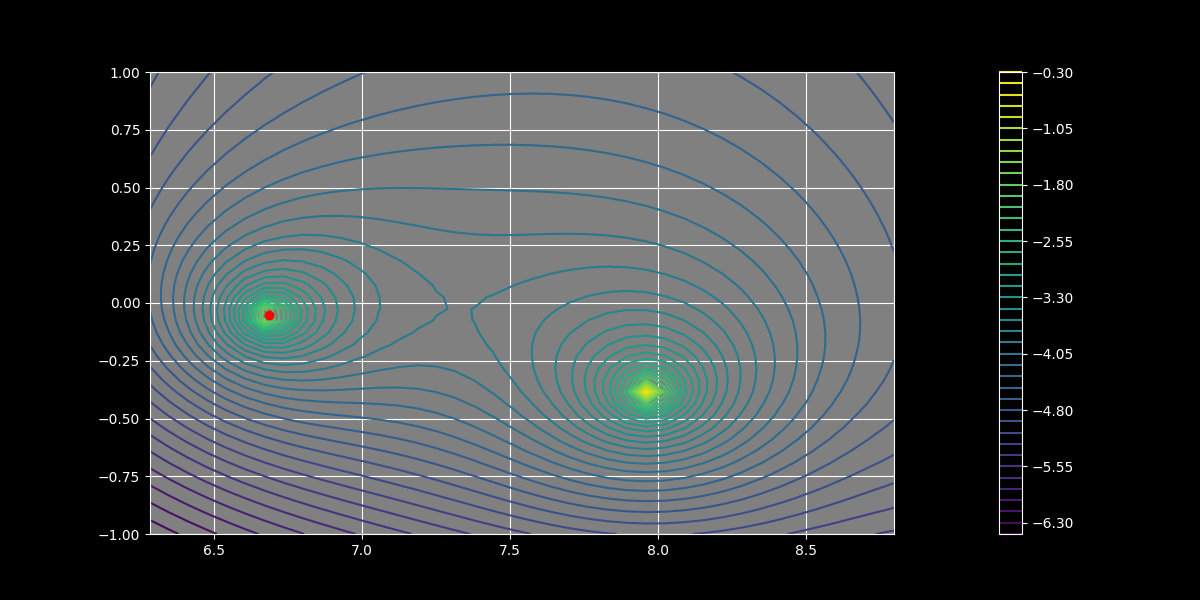

In [19]:
plotlogf(integrand_2, A.K_low, 1.4*A.K_low, -1, 1, iref=40, rref=40, levels=40)
plt.plot(Z.real, Z.imag, 'ro');

## Contour Integration around poles

Now we want to see why we get zero when integrating around the poles.  With the paper method we get non-trivial leaky modes (in the ``wrong'' places, from this, but not with our method.

In [29]:
circ_contour = {'center': Z, 'radius': 1.1e-6, 'N':10}

In [30]:
P_leaky = Propagator(f0=f0, Lx=-.5, Rx=.5, 
                     LZ=100, RZ=150, NZ=10, 
                     field_type='TE', conjugate=False,
                     sign='+1', circ_contour=circ_contour, paper_method=False)

 50% (5 of 10) |############             | Elapsed Time: 0:00:00 ETA:  00:00:00

### Plot resulting mode:

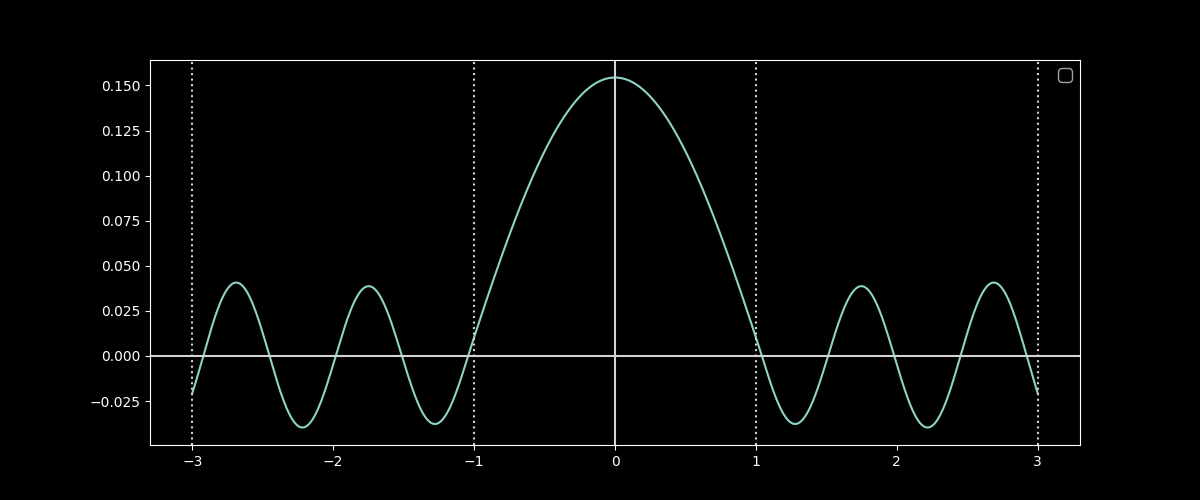

In [32]:
A.plot_field_1d(lambda x: -P_leaky.slice_propagate(x), part='real');

#### Plot transform along circle


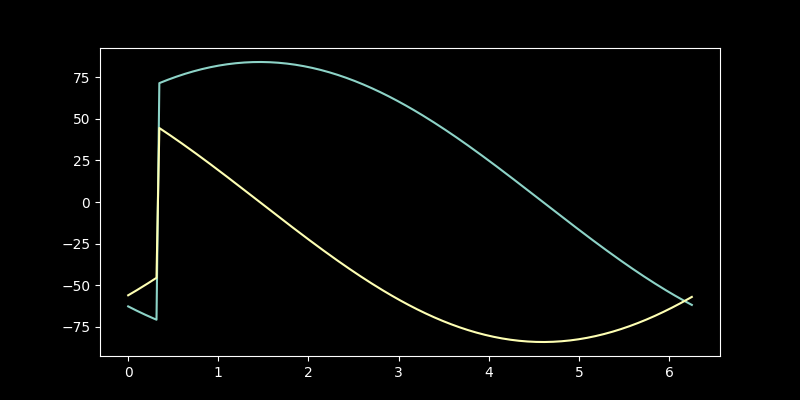

In [122]:
plt.close('all')
fig, ax = plt.subplots(1, figsize=(8,4))
ax.plot(P_leaky.ts,  P_leaky.alphas.real);
ax.plot(P_leaky.ts,  P_leaky.alphas.imag);


### Problem with this is that as we refine circle, mode goes to zero.  But it is around a pole.

Let's look at the nearby fields to see what's going on.

In [198]:
r = 1e-14
N = 100
ts = np.linspace(0, 2*np.pi,N+1)[:-1]
center = Z

Z_near = Z + r*np.exp(1j*ts[0])
dt = ts[1] - ts[0]

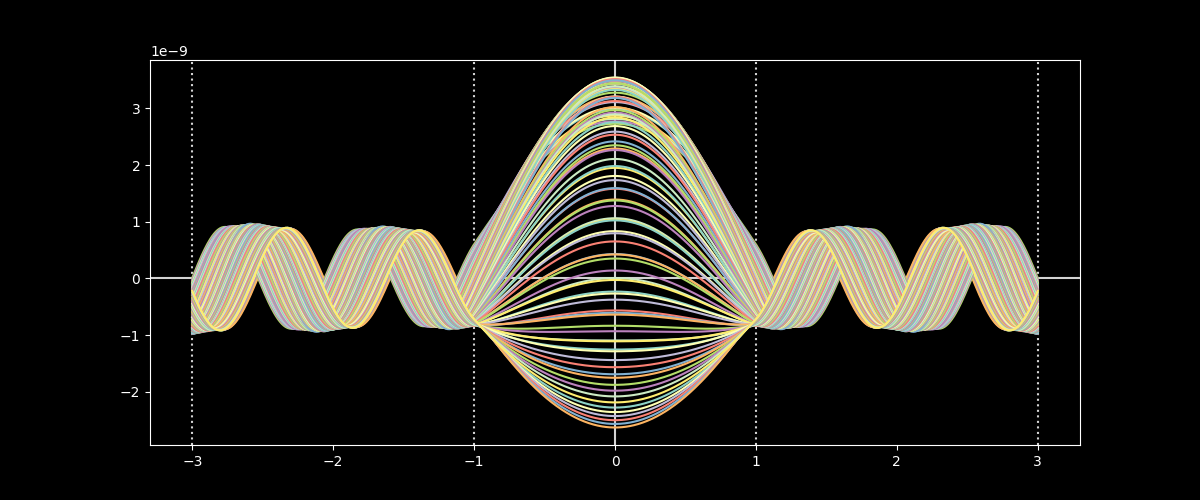

In [199]:
part='real'
A.plot_field_1d(lambda x: -A.fields_Z(Z_near, mode_type='radiation', paper_method=False)(x)* 1j *np.exp(1j*ts[0])*r *dt, part=part);
for i in range(1, len(ts)):
    Z_near = Z + r*np.exp(1j*ts[i])
    A.add_1d_plot(lambda x: -A.fields_Z(Z_near, mode_type='radiation', paper_method=False)(x)* 1j *np.exp(1j*ts[i])* r * dt, part=part)

Note that the above plots don't include the contribution from the transform, but it still isn't enough to overcome shrinking radius.

# Fix x and z and plot integrand

We let x=z=0.  Then integrand is $\hat f_\mathcal{A}(Z) \Big( A_{1,0} + A_{2,0}\Big).$  My main issue with the above is that the contour integrals around the pole are not constant as we change the radius of the contour.  If the integrand is analytic on the punctured disk, the contour integrals shouldn't change as we change the radius.  

So let's look at this integrand.

In [318]:
integrand_00 = lambda Z: (coeffs(Z, 1) + coeffs(Z, 2))* P_even.transform(Z)
integrand_00_real = lambda Z: ((coeffs(Z, 1) + coeffs(Z, 2))* P_even.transform(Z)).real
integrand_00_imag = lambda Z: ((coeffs(Z, 1) + coeffs(Z, 2))* P_even.transform(Z)).imag


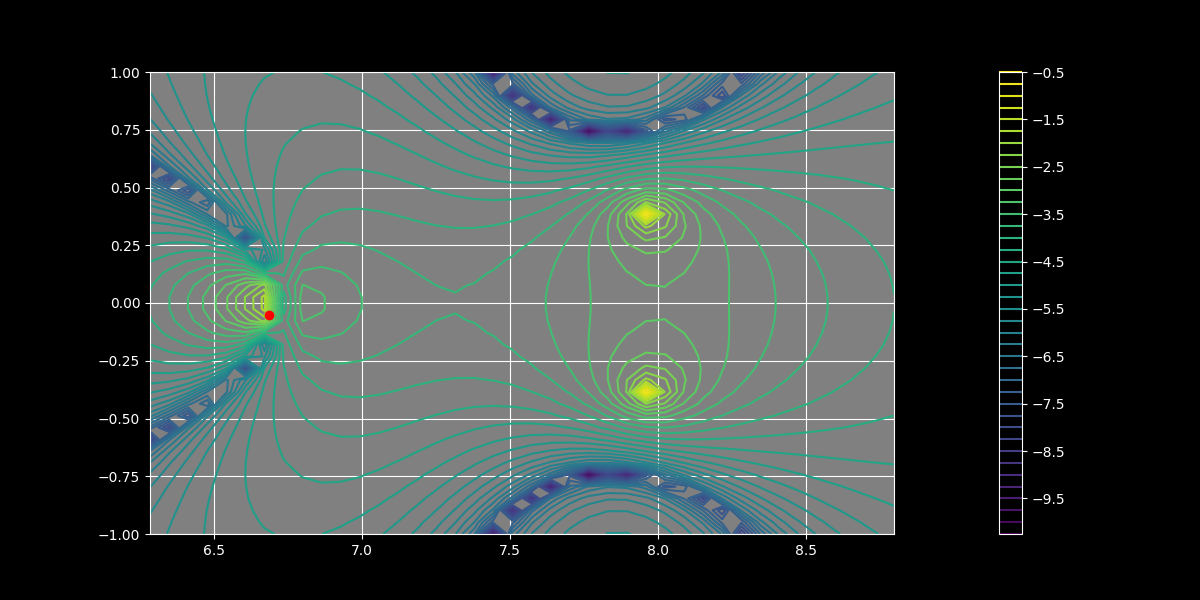

In [319]:
plotlogf(integrand_00_real, A.K_low, 1.4*A.K_low, -1, 1, iref=40, rref=40, levels=40)
plt.plot(Z.real, Z.imag, 'ro');

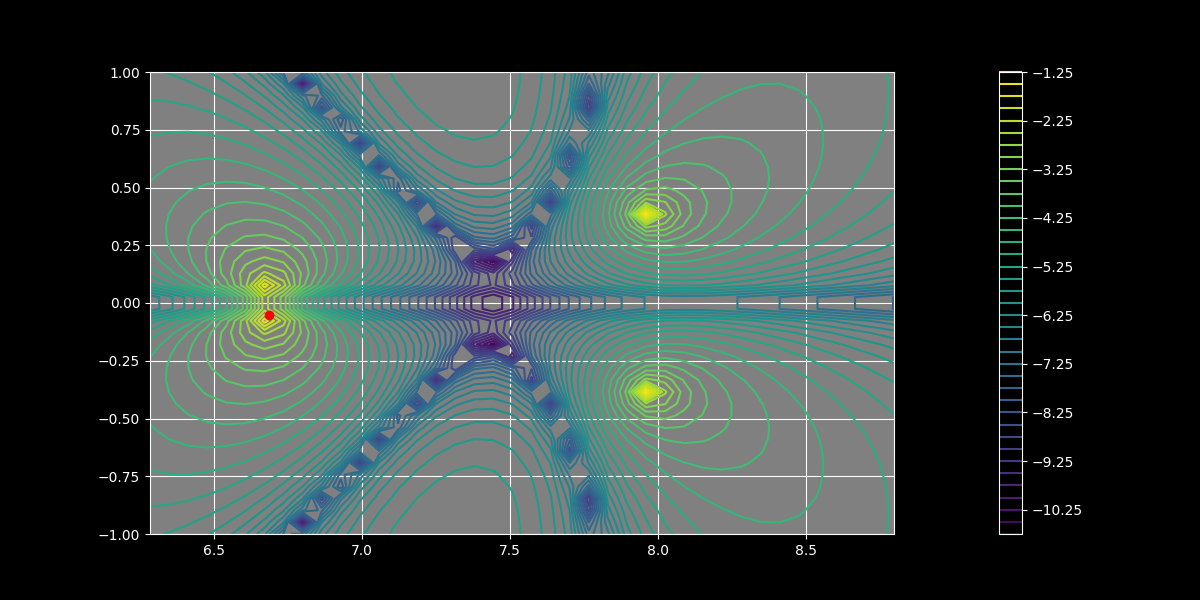

In [321]:
plotlogf(integrand_00_imag, A.K_low, 1.4*A.K_low, -1, 1, iref=40, rref=40, levels=40)
plt.plot(Z.real, Z.imag, 'ro');

### Zoom in

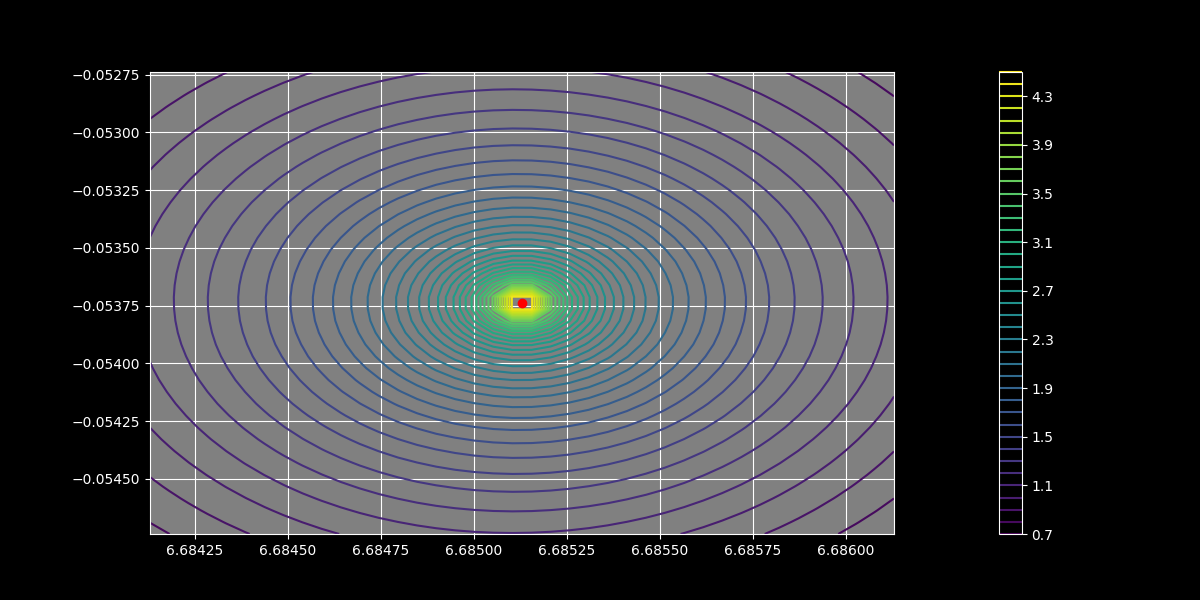

In [322]:
plotlogf(integrand_00_real, Z.real-.001, Z.real+.001, Z.imag-.001, Z.imag+.001, iref=40, rref=40, levels=40)
plt.plot(Z.real, Z.imag, 'ro');

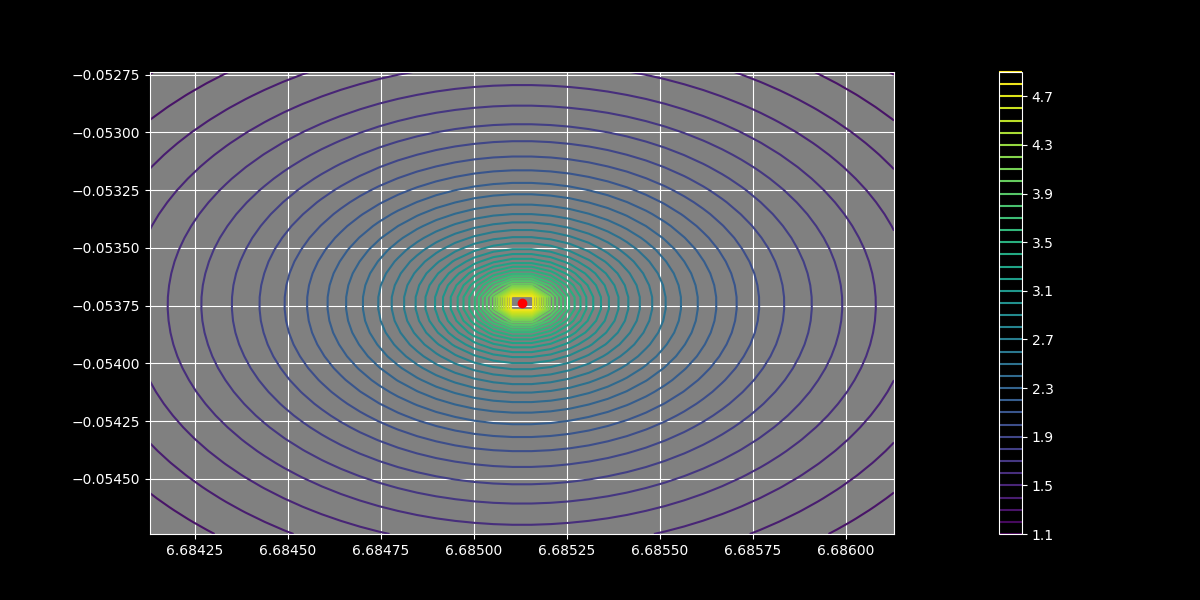

In [323]:
plotlogf(integrand_00_imag, Z.real-.001, Z.real+.001, Z.imag-.001, Z.imag+.001, 
         iref=40, rref=40, levels=40)
plt.plot(Z.real, Z.imag, 'ro');

## Observations

It looks like the integrand is nice, so the contour integrals around the pole shouldn't be dependent on the radius of the contour.  But they are... so maybe my contour integral routine is faulty.